In [1]:
%load_ext autoreload

In [11]:
%autoreload 2
import cmath
from datetime import datetime
import itertools as it
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.integrate import odeint, simpson
from scipy.signal import argrelextrema, butter, lfilter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import embed_signal, simulate_vdp, compute_VAR_p_over_lamb, construct_dictionary, perform_stability_analysis, get_stability_results, predict_EDMD, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Simulate Lorenz

In [77]:
def L63(vec, t, sigma=10, rho=28, beta=8/3):
    x, y, z = vec[0], vec[1], vec[2]
    d = np.zeros(3)
    d[0] = sigma*(y - x)
    d[1] = x*(rho - z) - y
    d[2] = x*y - beta*z
    
    return d

# SIMULATION PARAMETERS
dt = 0.01
# v0 = np.random.randn(3)*0.01
v0 = np.array([0.85957, 1.7318, 1.2865])
# time_vals = np.arange(0.0, 75.0, dt)
time_vals = np.arange(0.0, 500, dt)
# time_vals = np.arange(0.0, 50, dt)
# time_vals = np.arange(0.0, 2400, dt)

# SIMULATE
v = odeint(lambda v, t: L63(v, t), v0, time_vals)

# projection_dim = 1
# data = v @ np.random.randn(3, projection_dim)
# data = v[1000:, [0]] # remove the transient
# data -= data.mean(axis=0) # remove the mean
data = v[1000:]

# Pick Tau

In [22]:
num_lags = 200
delayed_mis = np.zeros((data.shape[1], num_lags))

iterator = tqdm(total=data.shape[1]*num_lags)
for i in range(data.shape[1]):
    for lag in range(num_lags):
        delayed_mis[i, lag] = delay.mi(data[:data.shape[0]-lag, i], data[lag:, i], bins=64)
        
        iterator.update()
iterator.close()

  0%|          | 0/600 [00:00<?, ?it/s]

In [23]:
tau = argrelextrema(delayed_mis.mean(axis=0), np.less)[0][0]

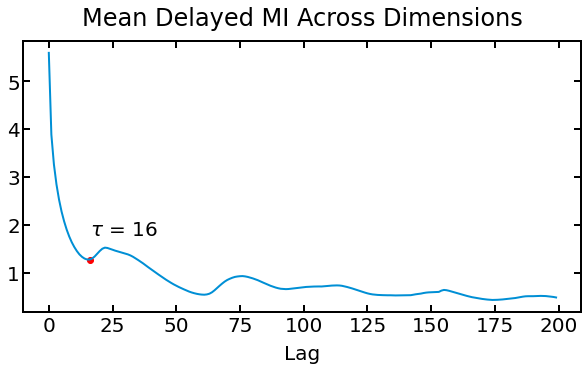

In [24]:
plt.plot(delayed_mis.mean(axis=0))
plt.scatter(tau, delayed_mis.mean(axis=0)[tau], c='red')
plt.text(tau, delayed_mis.mean(axis=0)[tau] + 0.5, fr"$\tau$ = {tau}" )
plt.xlabel('Lag')
plt.title("Mean Delayed MI Across Dimensions")
plt.show()

In [78]:
tau = 1
data = data[np.arange(0, data.shape[0], tau)]

In [79]:
dt_eff = tau*dt
dt_eff

0.01

# VAR(p)

In [80]:
data.shape

(49000, 3)

In [81]:
lags = np.arange(1, 15.1, 1, dtype=int)

In [82]:
print(f"min_window = {int(np.ceil(lags[-1]*data.shape[1]*2*dt_eff))}")
print(f"max_window = {int(np.ceil(10000*dt_eff))}")

min_window = 1
max_window = 100


In [83]:
lamb_vals = lamb_vals = [0, 1e-12, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.05, 0.1, 0.5, 0.75, 1, 2, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60]
# windows = np.array([25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000])
windows = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [84]:
analysis_kwargs = dict(
    windows=windows,
    lags=lags,
    method='VAR(p)',
    T_pred=50,
    num_window_samples=5,
    dt=dt_eff,
    lamb=lamb_vals,
    trim_CIs=False,
    use_lamb_for_full_results=True,
    PCA_dim=-1,
    normalize=False,
    verbose=2
)

In [85]:
ret = perform_stability_analysis(data, **analysis_kwargs)
VAR_results, grid_search_df, test_mse_mat, window, p, lamb_full = ret

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [93]:
CIs

array([0.99213665, 0.99213665, 0.97666068, 0.97666068, 0.97348434,
       0.97348434, 0.9712503 , 0.9712503 , 0.96629808, 0.96629808,
       0.96552435, 0.96552435, 0.96052405, 0.96052405, 0.95857418,
       0.95857418, 0.95294893, 0.95294893, 0.95065396, 0.95065396,
       0.94471265, 0.94471265, 0.94030441, 0.94030441, 0.93468487,
       0.93468487, 0.92339286, 0.90646496, 0.90646496, 0.85660681,
       0.85660681, 0.85458654, 0.85458654, 0.83021711, 0.83021711,
       0.80791343, 0.80791343, 0.80428688, 0.80428688, 0.79937174,
       0.79937174, 0.79856647, 0.79856647, 0.78862437, 0.78862437,
       0.        ])

In [86]:
row = VAR_results.iloc[0]
CIs = row.criticality_inds
np.log(CIs[CIs != 0])/dt_eff

array([ -0.78944332,  -0.78944332,  -2.36159939,  -2.36159939,
        -2.68735446,  -2.68735446,  -2.91710674,  -2.91710674,
        -3.42829198,  -3.42829198,  -3.50839599,  -3.50839599,
        -4.02762557,  -4.02762557,  -4.23083236,  -4.23083236,
        -4.81939619,  -4.81939619,  -5.06051505,  -5.06051505,
        -5.6874469 ,  -5.6874469 ,  -6.1551619 ,  -6.1551619 ,
        -6.75458414,  -6.75458414,  -7.97005002,  -9.82028982,
        -9.82028982, -15.47762665, -15.47762665, -15.71375032,
       -15.71375032, -18.60680299, -18.60680299, -21.33003635,
       -21.33003635, -21.77992537, -21.77992537, -22.39291906,
       -22.39291906, -22.49370741, -22.49370741, -23.74651586,
       -23.74651586])

In [114]:
# preds, tv, pb_mse, pb = predict_VAR_p(data[row.end_ind:row.end_ind + 500], row.coefs, row.intercept, persistence_baseline=2)
preds, tv, pb_mse, pb = predict_VAR_p(data[row.start_ind:row.end_ind], row.coefs, row.intercept, persistence_baseline=2, tail_bite=True)

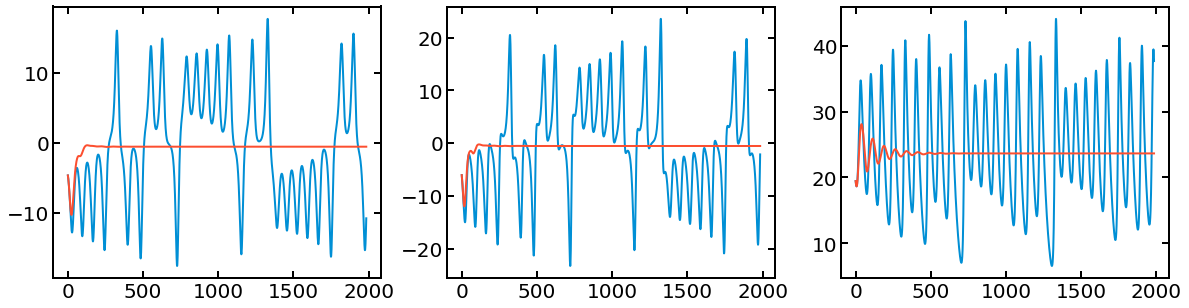

In [115]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for ind in range(3):
    ax = axs[ind]
    ax.plot(tv[:, ind])
    ax.plot(preds[:, ind])

In [97]:
window, p, lamb_full

(20, 15, 2e-13)

In [100]:
chaotic_rows = grid_search_df[grid_search_df.criticality_inds.apply(lambda x: (x > 1).sum() > 0)]

In [103]:
chaotic_row = chaotic_rows.iloc[chaotic_rows.test_mse.argmin()]

In [105]:
chaotic_row

explained_variance                                                 None
lamb_mses             [2.4268860501484193e-11, 2.457024474284562e-10...
lamb                                                                0.0
coefs                 [[[-4.227691328113813, 0.5234596099456787, 0.0...
intercept             [-2.737125874077706e-07, -9.509278750652328e-0...
eigs                  [(-0.8311952885064033+0.23778799625375707j), (...
criticality_inds      [1.0023909815745613, 1.0023909815745613, 0.999...
S                     [2204.6041564508514, 702.9128590251522, 257.42...
info_criteria                                                      None
train_mse                                                           0.0
test_mse                                                            0.0
pb_mse_train                                                   0.317855
pb_mse_test                                                    0.181426
start_ind                                                       

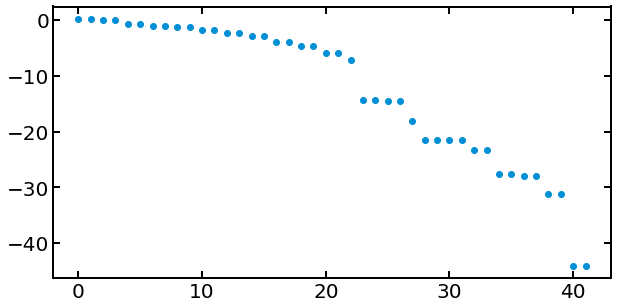

In [113]:
continuous_exps = np.log(chaotic_row.criticality_inds[chaotic_row.criticality_inds != 0])/dt_eff
plt.scatter(np.arange(len(continuous_exps)), continuous_exps)

# Better Prediction?

In [260]:
dt = 0.01
total_time = 3000
mu_vals=np.array([0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5])
method = 'scipy'
subsample = False
verbose = 2
signals, taus, delayed_mis = simulate_vdp(dt, total_time, mu_vals, method, subsample, verbose)

  0%|          | 0/12 [00:00<?, ?it/s]

In [307]:
data = signals['mu = 2.0']

In [321]:
window_length = 5000
window_data = data[:window_length]
p = 1
window_data = embed_signal(window_data, p, 1, direction='reverse')

In [322]:
Psi_minus = window_data[:-1].T
Psi_plus = window_data[1:].T

In [323]:
U, S, Vh = np.linalg.svd(Psi_minus)
V = Vh.T

In [324]:
K_0 = Psi_plus @ V[:, :len(S)] @ np.diag(1/S) @ U.T

In [325]:
K_0.shape

(2, 2)

In [326]:
eigvals, eigvecs = np.linalg.eig(K_0)

In [327]:
np.abs(eigvecs @ np.diag(eigvals) @ np.linalg.inv(eigvecs) - K_0).sum()

3.5120822594071857e-16

In [328]:
# T_pred = 2500
# test_data = data[window_length - p:window_length + T_pred]
test_data = data[:window_length]
test_data = embed_signal(test_data, p, 1, direction='reverse')
Psi_test_minus = test_data[:-1].T
Psi_test_plus = test_data[1:].T

In [329]:
b = np.linalg.inv(eigvecs) @ Psi_test_plus[:, 0]

In [330]:
eigval_mults = np.zeros((len(eigvals), Psi_test_plus.shape[1]), dtype='complex')
eigval_mults[:, 0] = eigvals
for i in range(1, Psi_test_plus.shape[1]):
    eigval_mults[:, i] = eigval_mults[:, i - 1]*eigvals

In [331]:
Psi_pred = eigvecs @ np.diag(b) @ eigval_mults
Psi_pred = np.real(Psi_pred)

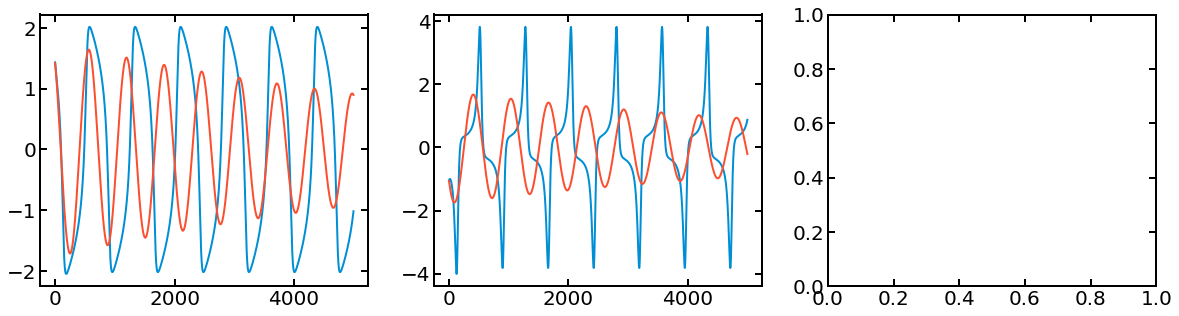

In [332]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
for ind in range(2):
    ax = axs[ind]
    ax.plot(Psi_test_plus[ind])
    ax.plot(Psi_pred[ind])

In [283]:
np.sort(np.real(np.array([cmath.log(e) for e in eigvals])/dt))[::-1]

array([  -0.17092864,   -0.17092864,   -0.4942758 ,   -0.4942758 ,
         -0.76563498,   -0.76563498,   -1.11516671,   -1.11516671,
         -2.47007832,   -2.47007832,   -7.37983627,   -7.37983627,
         -9.58009213,   -9.58009213,  -11.64358811,  -11.64358811,
        -14.50402952,  -14.50402952,  -14.5177878 ,  -14.5177878 ,
        -14.55519894,  -14.55519894,  -15.94513553,  -15.94513553,
        -16.75702563,  -16.75702563,  -21.58847547,  -21.58847547,
        -70.88727767, -109.0934673 ])

In [286]:
np.sort(np.log(np.abs(eigvals))/dt)[::-1]

array([  -0.17092864,   -0.17092864,   -0.4942758 ,   -0.4942758 ,
         -0.76563498,   -0.76563498,   -1.11516671,   -1.11516671,
         -2.47007832,   -2.47007832,   -7.37983627,   -7.37983627,
         -9.58009213,   -9.58009213,  -11.64358811,  -11.64358811,
        -14.50402952,  -14.50402952,  -14.5177878 ,  -14.5177878 ,
        -14.55519894,  -14.55519894,  -15.94513553,  -15.94513553,
        -16.75702563,  -16.75702563,  -21.58847547,  -21.58847547,
        -70.88727767, -109.0934673 ])